**Import libraries**

In [1]:
# !pip install -U tensorflow==2.7.0
# !pip install -U tensorflow-quantum==0.7.2

import cirq
import sympy
import numpy as np
import tensorflow as tf
import tensorflow_quantum as tfq
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit

2023-10-18 00:06:38.973736: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:925] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-18 00:06:39.007543: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:925] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-18 00:06:39.007617: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:925] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-18 00:06:39.009091: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate

**Generate training data**

In [2]:
q = cirq.GridQubit(0, 0)
add_noise = lambda x: x + np.random.normal(0, 0.25 * np.pi)

rotate_by_90deg = [cirq.Circuit(
        cirq.rx(add_noise(0.5 * np.pi))(q), 
        cirq.ry(add_noise(0))(q)
        ) for _ in range(100)]

rotate_by_270deg = [cirq.Circuit(
        cirq.rx(add_noise(1.5 * np.pi))(q), 
        cirq.ry(add_noise(0))(q)
        ) for _ in range(100)]

data = tfq.convert_to_tensor( rotate_by_90deg + rotate_by_270deg)
label = np.array([1] * 100 + [0] * 100)

**Visualize training data**

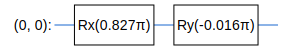

In [3]:
circuit = cirq.Circuit(
        cirq.rx(add_noise(0.5 * np.pi))(q), 
        cirq.ry(add_noise(0))(q))
SVGCircuit(circuit)

**Create circuit for PQC layer**

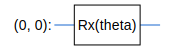

In [4]:
theta = sympy.Symbol('theta')
pqc_circuit = cirq.Circuit(cirq.rx(theta)(q))
display(SVGCircuit(pqc_circuit))

**Build and train model**

In [5]:
model = tf.keras.Sequential([
    tf.keras.Input(shape=() ,dtype=tf.string),
    tfq.layers.PQC(pqc_circuit, cirq.Z(q)),
    tf.keras.layers.Dense(2, activation='softmax')])

model.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    loss='sparse_categorical_crossentropy',
    metrics='sparse_categorical_accuracy')
history = model.fit(data, label, epochs=200, verbose=0) # silent mode
print('accuracy: ', history.history['sparse_categorical_accuracy']
                                    [tf.argmin(history.history['loss'])])
print('theta: ', model.layers[0].get_weights()[0])

accuracy:  0.949999988079071
theta:  [1.6593333]


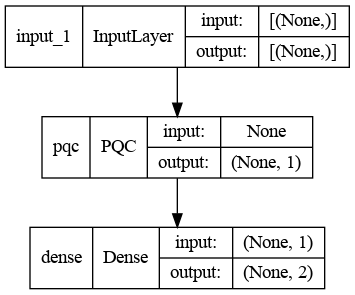

In [6]:
tf.keras.utils.plot_model(model, show_shapes=True)